In [5]:
import FinanceDataReader as fdr 
import matplotlib.pyplot as plt
df = fdr.DataReader("TQQQ")

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense , Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
# from sklearn import preprocessing
# pip install -U finance-datareader
# import FinanceDataReader as fdr
def make_sequence_dataset(feature, label, window_size):
    feature_list = [] 
    label_list = []

    for i in range(len(feature) - window_size):
        feature_list.append(feature[i:i+window_size+1]) # added label
        label_list.append(label[i+window_size])

    return np.array(feature_list), np.array(label_list)

def survive_open(x,feature_cols,label_cols):
    
    index = [i for i,item in enumerate(feature_cols) if (item not in label_cols)]
    for i in range(len(x)):
        x[i][40][index] = np.zeros(len(index))
    return x

raw_df = df

# 정규화 작업

scaler = MinMaxScaler()
scale_cols = ['Close', 'Open', 'High', 'Low', 'Volume', 'Change']
scaled_df = scaler.fit_transform(raw_df[scale_cols]) # scaler.inverse_transform(X)
scaled_df = pd.DataFrame(scaled_df , columns=scale_cols)


feature_cols = ['Close', 'Open', 'High', 'Low', 'Volume', 'Change']
label_cols = ['High','Low']

label_np   = pd.DataFrame(scaled_df, columns=label_cols).to_numpy()
feature_np = pd.DataFrame(scaled_df, columns = feature_cols).to_numpy()

window_size = 40
x,y = make_sequence_dataset(feature_np, label_np, window_size)
x = survive_open(x,feature_cols,label_cols)

# train data 와 test data로 구분(7:3 비율) X,y : DataFrame

from sklearn.model_selection import train_test_split
#xtr,xval,ytr,yval = train_test_split(x,y,train_size=0.8,shuffle=True) #train:val = 4:1
xtr,xte,ytr,yte = train_test_split(x,y,train_size=0.4,shuffle=True) #train:val:test = 4:3:3 ≈ 1186:890:890
xval, xte, yval, yte = train_test_split(xte, yte, test_size=0.5, random_state=10,shuffle=True) 


model = Sequential()
model.add( LSTM(128,
             activation = 'tanh',
             input_shape = xtr[0].shape)) #41,8

model.add(Dense (64, activation = 'linear'))
model.add(Dense (2, activation = 'linear'))
# model.summary()
# 모델 컴파일 및 학습
# from livelossplot import PlotLossesKeras # pip install livelossplot

model.compile(loss='mse', optimizer='adam', metrics=['mae','acc'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)
# model.fit(xtr,ytr, validation_data=(xval,yval), epochs=200,batch_size=32,callbacks=[early_stop,PlotLossesKeras()])
model.fit(xtr,ytr, validation_data=(xval,yval), epochs=200,batch_size=32,callbacks=[early_stop])

def inverse_scaling(pre,scaler=scaler,feature_cols=feature_cols,label_cols=label_cols):
    index = []
    zeros = np.zeros( (pre.shape[0],len(feature_cols)) )
    for item in label_cols:
        index.append(feature_cols.index(item) )
    zeros[:,index] = pre
    inverse_pred = scaler.inverse_transform(zeros)[:,index]
    return inverse_pred

Epoch 1/200
38/38 [==============================] - 1s 10ms/step - loss: 0.0083 - mae: 0.0468 - acc: 0.4878 - val_loss: 0.0010 - val_mae: 0.0189 - val_acc: 0.7855
Epoch 2/200
38/38 [==============================] - 0s 5ms/step - loss: 5.1627e-04 - mae: 0.0139 - acc: 0.4962 - val_loss: 2.0431e-04 - val_mae: 0.0075 - val_acc: 0.3408
Epoch 3/200
38/38 [==============================] - 0s 5ms/step - loss: 3.1247e-04 - mae: 0.0087 - acc: 0.5700 - val_loss: 1.9790e-04 - val_mae: 0.0079 - val_acc: 0.7709
Epoch 4/200
38/38 [==============================] - 0s 6ms/step - loss: 3.2441e-04 - mae: 0.0090 - acc: 0.5683 - val_loss: 1.9140e-04 - val_mae: 0.0068 - val_acc: 0.2715
Epoch 5/200
38/38 [==============================] - 0s 7ms/step - loss: 2.8916e-04 - mae: 0.0080 - acc: 0.5901 - val_loss: 1.8323e-04 - val_mae: 0.0071 - val_acc: 0.2145
Epoch 6/200
38/38 [==============================] - 0s 6ms/step - loss: 2.7277e-04 - mae: 0.0084 - acc: 0.5524 - val_loss: 1.6238e-04 - val_mae: 0.0073

In [10]:
import joblib

In [11]:
import os
save_dir = './models'
yesterday = '2021-02-18'
model.save(os.path.join(save_dir,f'{yesterday}_model.h5'))

import joblib
scaler_filename = "scaler.save"
joblib.dump(scaler, os.path.join(save_dir,f'{yesterday}_scaler.pkl') )

['./models/2021-02-18_scaler.pkl']

0.14320459117065346


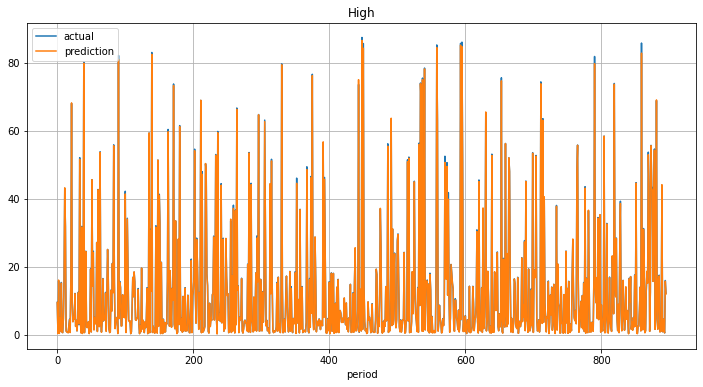

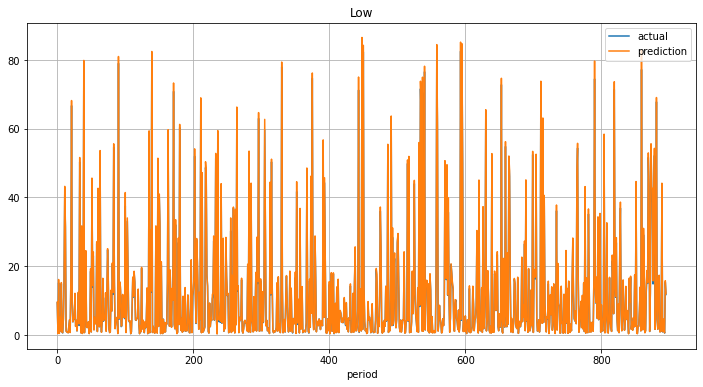

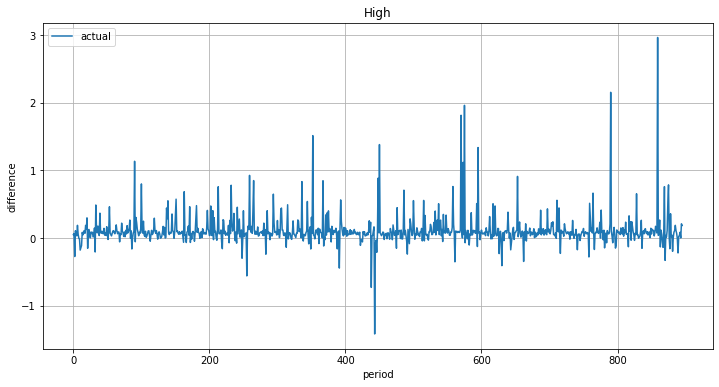

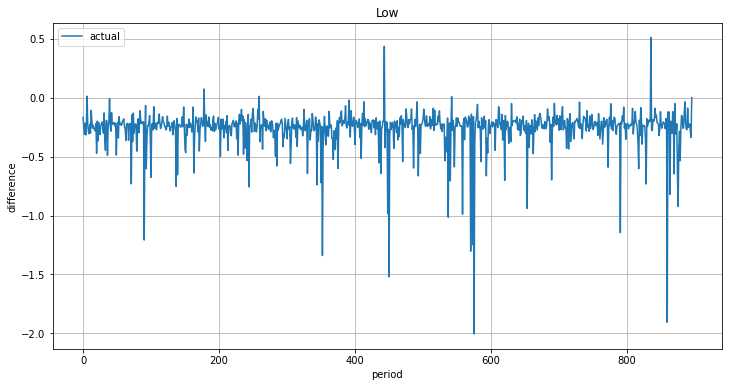

In [4]:

def inverse_scaling(pre,scaler=scaler,feature_cols=feature_cols,label_cols=label_cols):
    index = []
    zeros = np.zeros( (pre.shape[0],len(feature_cols)) )
    for item in label_cols:
        index.append(feature_cols.index(item) )
    zeros[:,index] = pre
    inverse_pred = scaler.inverse_transform(zeros)[:,index]
    return inverse_pred

pred = model.predict(xte)
pred = inverse_scaling(pred)
yte  = inverse_scaling(yte)
pred_high,pred_low = pred[:,0],pred[:,1]
high,low = yte[:,0],yte[:,1]

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
print(mae(pred_high,high) )

plt.figure(figsize=(12,6))
plt.title('High')
plt.ylabel('')
plt.xlabel('period')
plt.plot(yte[:,0], label='actual')
plt.plot(pred_high, label='prediction')
plt.grid()
plt.legend(loc='best')

#plt.plot(raw_df['Adj Close'], label='Adj Close', color='b')


plt.show()

plt.figure(figsize=(12,6))
plt.title('Low')
plt.ylabel('')
plt.xlabel('period')
plt.plot(yte[:,1], label='actual')
plt.plot(pred_high, label='prediction')
plt.grid()
plt.legend(loc='best')

#plt.plot(raw_df['Adj Close'], label='Adj Close', color='b')


plt.show()

plt.figure(figsize=(12,6))
plt.title('High')
plt.ylabel('difference')
plt.xlabel('period')
plt.plot(high-pred_high, label='actual')
# plt.plot(pred_high, label='prediction')
plt.grid()
plt.legend(loc='best')

#plt.plot(raw_df['Adj Close'], label='Adj Close', color='b')


plt.show()

plt.figure(figsize=(12,6))
plt.title('Low')
plt.ylabel('difference')
plt.xlabel('period')
plt.plot(low-pred_low, label='actual')
# plt.plot(pred_high, label='prediction')
plt.grid()
plt.legend(loc='best')

#plt.plot(raw_df['Adj Close'], label='Adj Close', color='b')


plt.show()